In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
df = pd.read_csv('data_3.csv',index_col=[0],parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 1949-01-01 to 2018-01-01
Data columns (total 18 columns):
primary-energy                  69 non-null float64
gdp                             69 non-null float64
population                      69 non-null float64
PPIACO                          70 non-null float64
miles-per-vehicle               68 non-null float64
crude_oil                       69 non-null float64
natural-gas                     64 non-null float64
pri-energy-production           69 non-null float64
Electricity-price               69 non-null float64
coal-price                      63 non-null float64
Energy-export                   69 non-null float64
Energy-import                   69 non-null float64
Heating-degree                  69 non-null float64
Cooling-degree                  69 non-null float64
CO2                             69 non-null float64
renewable                       69 non-null float64
Vehicle-fuel-economy            68 non-null f

## Important features

In [3]:
data = df[['primary-energy','CO2','Electricity-price','crude_oil']].dropna()

In [4]:
# Perform Dickey-fuller test  for stationality
from statsmodels.tsa.stattools import adfuller

In [5]:
for i in data.columns: 
    x = data[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('')

primary-energy
ADF Statistic: -1.9374480031944872
p-value: 0.3146545468935985

CO2
ADF Statistic: -2.04735545139893
p-value: 0.26620285798600263

Electricity-price
ADF Statistic: -1.6692550827155261
p-value: 0.44701871099357604

crude_oil
ADF Statistic: -2.413940659737715
p-value: 0.13784035671467798



## Transform data

In [6]:
diff = data.diff().dropna()
diff.head()

,primary-energy,CO2,Electricity-price,crude_oil
1950-01-01,2634.265,175.355,36931.992,-0.03
1951-01-01,2358.262,144.641,38841.257,0.02
1952-01-01,-226.205,-53.313,25879.377,0.00
1953-01-01,916.643,63.519,40052.936,0.15
1954-01-01,-1025.086,-114.640,27946.896,0.10


In [7]:
for i in diff.columns: 
    x = diff[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('')

primary-energy
ADF Statistic: -3.537455809356326
p-value: 0.007075671562378174

CO2
ADF Statistic: -3.204831388959297
p-value: 0.01970671720201473

Electricity-price
ADF Statistic: -2.723159004905201
p-value: 0.07011576875834424

crude_oil
ADF Statistic: -3.5993674879538826
p-value: 0.005773131543808486



In [8]:
diff['CO2']=diff['CO2'].diff()
diff.head()

,primary-energy,CO2,Electricity-price,crude_oil
1950-01-01,2634.265,NaN,36931.992,-0.03
1951-01-01,2358.262,-30.714,38841.257,0.02
1952-01-01,-226.205,-197.954,25879.377,0.00
1953-01-01,916.643,116.832,40052.936,0.15
1954-01-01,-1025.086,-178.159,27946.896,0.10


In [9]:
result = adfuller(diff['CO2'].dropna())
print('CO2')
print('ADF Statistic:', result[0])
print('p-value:', result[1])


CO2
ADF Statistic: -11.580924556275916
p-value: 2.944309678297305e-21


In [10]:
diff = diff.dropna()
diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 1951-01-01 to 2017-01-01
Data columns (total 4 columns):
primary-energy       67 non-null float64
CO2                  67 non-null float64
Electricity-price    67 non-null float64
crude_oil            67 non-null float64
dtypes: float64(4)
memory usage: 2.6 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001838A780>,
      dtype=object)

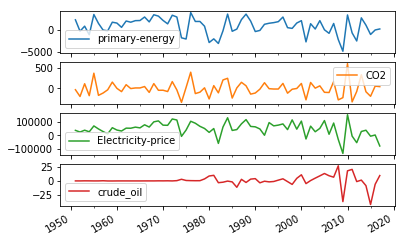

In [11]:
diff.plot(subplots=True)

## Split data

In [12]:
x_train = diff.iloc[:58,:]
y_train = diff.iloc[:58,0]

x_test = diff.iloc[58:,:]
y_test = diff.iloc[58:,0]

In [13]:
x_train.shape

(58, 4)

In [14]:
x_test.shape

(9, 4)

## Build Model

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [16]:
# make a VAR model
model = VAR(x_train,freq='AS-JAN')

In [17]:
model.select_order(3).summary()

,AIC,BIC,FPE,HQIC
0,48.31,48.45,9.555e+20,48.37
1,46.27,47.00*,1.249e+20,46.55
2,45.89,47.21,8.629e+19,46.40*
3,45.67*,47.57,7.080e+19*,46.40


In [18]:
res = model.fit(maxlags=3, ic='aic')

In [19]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Dec, 2018
Time:                     16:41:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    47.5679
Nobs:                     55.0000    HQIC:                   46.4039
Log likelihood:          -1516.09    FPE:                7.08047e+19
AIC:                      45.6700    Det(Omega_mle):     3.03024e+19
--------------------------------------------------------------------
Results for equation primary-energy
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     2134.942316       783.535383            2.725           0.006
L1.primary-energy            0.788567         0.536653            1.469           0.142
L1.CO2                 

In [20]:
lag_order = res.k_ar
lag_order

3

## Predict and Compare with test set

In [21]:
pred = res.forecast(x_train.values[-lag_order:], 9)
pred

array([[-4.27167300e+03, -8.27422884e+01,  2.26216305e+04,
         1.36059648e+01],
       [-3.29078623e+03,  7.59830462e+00, -6.55253135e+04,
         1.12275343e+01],
       [-1.23602508e+03,  1.38160496e+02,  3.95003777e+04,
         1.61068247e+01],
       [-2.22131124e+03, -5.76443183e+01, -1.88788361e+04,
         1.48364829e+01],
       [-2.39516424e+03, -5.84487753e+01, -8.15273211e+03,
         9.29516012e+00],
       [-1.43976917e+03,  6.24075712e+01, -1.12340298e+03,
         1.27602457e+01],
       [-1.04770325e+03,  1.35137275e+01,  9.29523841e+03,
         1.21961527e+01],
       [-1.28561512e+03, -1.97958518e+01,  4.91827350e+03,
         1.04133650e+01],
       [-1.19228815e+03, -2.29171174e+01,  6.80757714e+03,
         1.02896686e+01]])

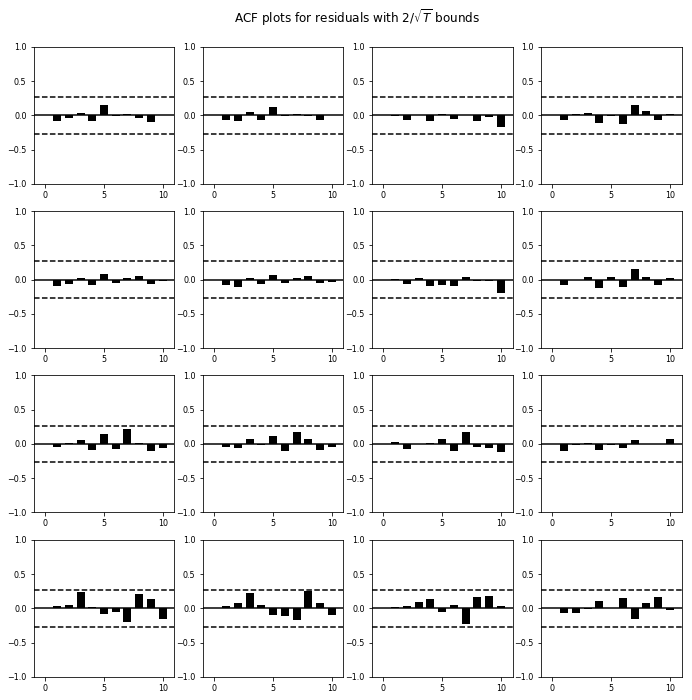

In [22]:
res.plot_acorr()
plt.show()

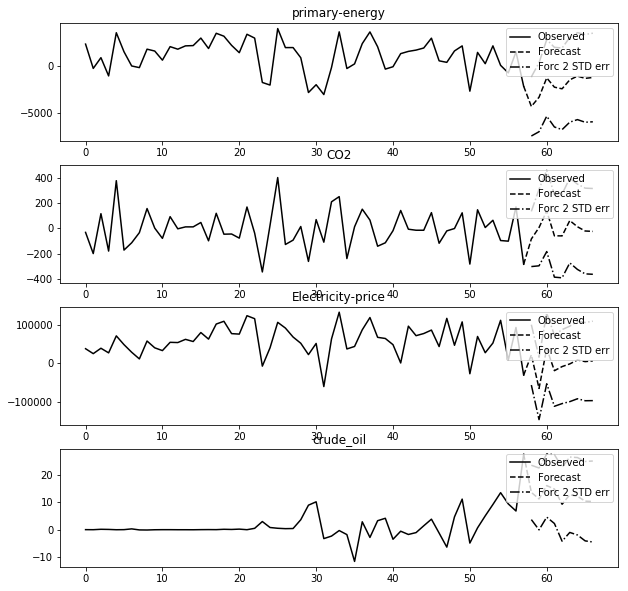

In [23]:
res.plot_forecast(9)
plt.show()

In [24]:
y_pre = pd.DataFrame(pred).iloc[:,0]
y_pre

0   -4271.673002
1   -3290.786235
2   -1236.025085
3   -2221.311239
4   -2395.164237
5   -1439.769170
6   -1047.703251
7   -1285.615123
8   -1192.288151
Name: 0, dtype: float64

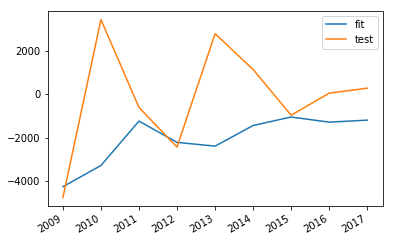

In [25]:
plt.plot(y_test.index,y_pre.values)
y_test.plot()
plt.legend(['fit','test'])

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
math.sqrt(mean_squared_error(y_pre.values, y_test.values))

3056.0214160422825

## Prediction for next 5 years
Use this model for the whole data and make a prediction

In [28]:
model_1 = VAR(diff,freq='AS-JAN')
model_1.select_order(3).summary()

,AIC,BIC,FPE,HQIC
0,50.32,50.45,7.120e+21,50.37
1,47.98,48.65*,6.872e+20,48.24
2,47.74,48.96,5.477e+20,48.22*
3,47.70*,49.45,5.302e+20*,48.39


In [29]:
result_1 = model.fit(maxlags=3, ic='aic')

In [30]:
lag_order = result_1.k_ar
lag_order

3

In [31]:
result_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Dec, 2018
Time:                     16:41:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    47.5679
Nobs:                     55.0000    HQIC:                   46.4039
Log likelihood:          -1516.09    FPE:                7.08047e+19
AIC:                      45.6700    Det(Omega_mle):     3.03024e+19
--------------------------------------------------------------------
Results for equation primary-energy
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     2134.942316       783.535383            2.725           0.006
L1.primary-energy            0.788567         0.536653            1.469           0.142
L1.CO2                 

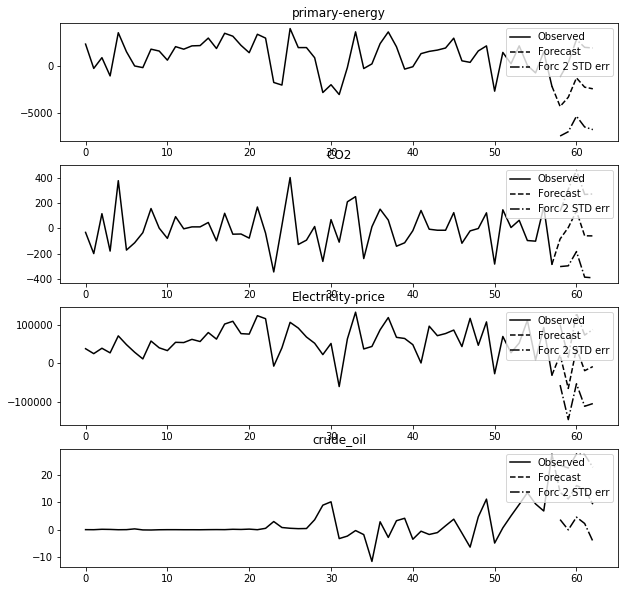

In [32]:
result_1.plot_forecast(5)
plt.show()

In [33]:
predicted = res.forecast(diff.values[-lag_order:], 5)

In [34]:
y_fore = pd.DataFrame(predicted).iloc[:,0]

In [35]:
d = pd.date_range('2017-01-01', '2022-01-01',freq='Y')
year = d + pd.offsets.MonthBegin(1)
year

DatetimeIndex(['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',
               '2022-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

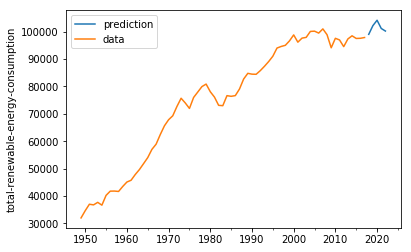

In [36]:
pd.DataFrame(index=year,data=y_fore.values.cumsum()+data.iloc[-1,0]).plot()
data['primary-energy'].plot()
plt.legend(['prediction','data'])
plt.ylabel('total-renewable-energy-consumption')
plt.show()

In [37]:
y_next5year = pd.DataFrame(index=year,data=y_fore.values.cumsum()+data.iloc[-1,0],columns=['Predicted-values'])
y_next5year

,Predicted-values
2018-01-01,99023.264404
2019-01-01,102202.200945
2020-01-01,104174.527145
2021-01-01,101172.951932
2022-01-01,100228.970811


In [38]:
# y_next5year.to_csv('Predicted-total-energy.csv')
